# Meta ESM for Protein Localization

In [1]:
!pip install -q accelerate biopython transformers evaluate datasets requests pandas wandb -U scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.8/212.8 KB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 46.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 89.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 KB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 KB 37.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 70.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 23.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 93.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 23.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 69.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True) # to enable connection to the drive

Mounted at /content/gdrive


In [3]:
drive_path = 'gdrive/MyDrive/Colab Notebooks/'

In [4]:
# Process fasta
from Bio import SeqIO
d = {'id':[], 'seq':[], 'label':[]}
files = ['cyto.fasta.txt', 'mito.fasta.txt', 'nucleus.fasta.txt', 'other.fasta.txt', 'secreted.fasta.txt']
for i in range(len(files)):
  for seq_record in SeqIO.parse(open(drive_path+files[i]),'fasta'):
    d['id'].append(seq_record.id)
    d['seq'].append(''.join(seq_record.seq))
    d['label'].append(i)

In [5]:
import pandas as pd
df = pd.DataFrame(d)
df.head()

,id,seq,label
0,sp|Q4JIM5|ABL2_MOUSE,MGQQVGRVGEAPGLQQPQPRGIRGSSAARPSGRRRDPAGRTADAGF...,0
1,sp|P15891|ABP1_YEAST,MALEPIDYTTHSREIDAEYLKIVRGSDPDTTWLIISPNAKKEYEPE...,0
2,sp|P35609|ACTN2_HUMAN,MNQIEPGVQYNYVYDEDEYMIQEEEWDRDLLLDPAWEKQQRKTFTA...,0
3,sp|P05095|ACTNA_DICDI,MSEEPTPVSGNDKQLLNKAWEITQKKTFTAWCNSHLRKLGSSIEQI...,0
4,sp|Q9Y2D8|ADIP_HUMAN,MGDWMTVTDPGLSSESKTISQYTSETKMSPSSLYSQQVLCSSIPLS...,0


In [6]:
sequences = df["seq"].tolist()
labels = df['label'].tolist()

## Splitting the data

Since the data we're loading isn't prepared for us as a machine learning dataset, we'll have to split the data into train and test sets ourselves.

In [7]:
from sklearn.model_selection import train_test_split

train_sequences, test_sequences, train_labels, test_labels = train_test_split(sequences, labels, 
                                                                              test_size=0.2, random_state=42)

## Tokenizing the data

In [8]:
from transformers import AutoTokenizer
model_checkpoint = 'facebook/esm2_t12_35M_UR50D'
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, truncation=True)

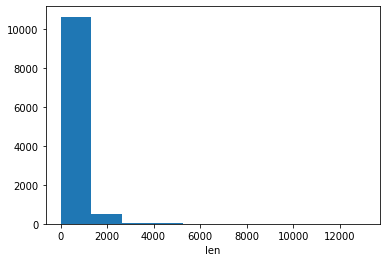

count    11224.000000
mean       526.114398
std        476.383537
min         11.000000
25%        262.000000
50%        407.000000
75%        650.000000
max      13100.000000
dtype: float64

In [10]:
# See the distribution of sequence lengths.
lengths = [len(i) for i in df.seq.values]
import matplotlib.pyplot as plt
plt.hist(lengths)
plt.xlabel('len')
plt.show()
pd.Series(lengths).describe() #sort_values().tail(20)

In [11]:
import numpy as np 
sum(np.array(lengths)>1024)/len(lengths)

0.10005345687811831

In [12]:
train_tokenized = tokenizer(train_sequences, padding='max_length', truncation=True, max_length=1024)
test_tokenized = tokenizer(test_sequences, padding='max_length', truncation=True, max_length=1024)

## Dataset creation

In [13]:
from datasets import Dataset
train_dataset = Dataset.from_dict(train_tokenized)
test_dataset = Dataset.from_dict(test_tokenized)

In [14]:
train_dataset = train_dataset.add_column("labels", train_labels)
test_dataset = test_dataset.add_column("labels", test_labels)

## Model loading

In [32]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

num_labels = max(train_labels + test_labels) + 1  # Add 1 since 0 can be a label
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=num_labels)

Some weights of the model checkpoint at facebook/esm2_t12_35M_UR50D were not used when initializing EsmForSequenceClassification: ['lm_head.dense.bias', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing EsmForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing EsmForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of EsmForSequenceClassification were not initialized from the model checkpoint at facebook/esm2_t12_35M_UR50D and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias'

In [33]:
from transformers.integrations import WandbCallback
import wandb
model_name = model_checkpoint.split("/")[-1]
batch_size = 1

output_dir = 'gdrive/MyDrive/Colab Notebooks/'

training_args = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=5,
    evaluation_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    save_strategy="epoch",
    auto_find_batch_size=True,
)

Next, we define the metric we will use to evaluate our models and write a `compute_metrics` function. We can load this from the `evaluate` library.

In [34]:
from evaluate import load
import numpy as np
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

metric = load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    f1 = f1_score(labels, predictions, average='weighted')
    accuracy = accuracy_score(labels, predictions)
    return {"f1": f1, "accuracy": accuracy}

And at last we're ready to initialize our `Trainer`:

In [23]:
from sklearn.model_selection import KFold
import numpy as np
# Assuming your dataset is loaded into 'dataset'
new_indices = list(range(len(train_dataset)))
train_dataset = train_dataset.select(new_indices)
# Assuming your dataset is loaded into 'dataset'
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Store evaluation metrics for each fold
metrics = []
train_indices = range(len(train_dataset))

for i, (train_index, val_index) in enumerate(kf.split(train_indices)):
    model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=num_labels)
    print(f"Training and evaluating fold {i+1}/{n_splits}...")
    # print(len(train_indices))
    train_dataset_fold = train_dataset.select(train_index)
    val_dataset_fold = train_dataset.select(val_index)

    trainer = Trainer(
        model,
        training_args,
        train_dataset=train_dataset_fold,
        eval_dataset=val_dataset_fold,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
        callbacks=[WandbCallback()],
    )
    
    # Train and evaluate the model on the current fold
    trainer.train()
    fold_eval_metrics = trainer.evaluate()
    
    # Save the evaluation metrics for the current fold
    metrics.append(fold_eval_metrics)
print(metrics)
# Calculate the average evaluation metrics across all folds
avg_metrics = {key: np.mean([m[key] for m in metrics]) for key in metrics[0].keys()}
print(f"Average evaluation metrics: {avg_metrics}")

Some weights of the model checkpoint at facebook/esm2_t12_35M_UR50D were not used when initializing EsmForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing EsmForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing EsmForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of EsmForSequenceClassification were not initialized from the model checkpoint at facebook/esm2_t12_35M_UR50D and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 

Training and evaluating fold 1/5...


Epoch,Training Loss,Validation Loss,F1,Accuracy
1,0.681400,0.464960,0.839556,0.839644


Some weights of the model checkpoint at facebook/esm2_t12_35M_UR50D were not used when initializing EsmForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing EsmForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing EsmForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of EsmForSequenceClassification were not initialized from the model checkpoint at facebook/esm2_t12_35M_UR50D and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 

Training and evaluating fold 2/5...


/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1,Accuracy
1,0.672100,0.424206,0.849030,0.847996


Some weights of the model checkpoint at facebook/esm2_t12_35M_UR50D were not used when initializing EsmForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing EsmForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing EsmForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of EsmForSequenceClassification were not initialized from the model checkpoint at facebook/esm2_t12_35M_UR50D and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 

Training and evaluating fold 3/5...


/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1,Accuracy
1,0.664300,0.445654,0.841076,0.840200


Some weights of the model checkpoint at facebook/esm2_t12_35M_UR50D were not used when initializing EsmForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing EsmForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing EsmForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of EsmForSequenceClassification were not initialized from the model checkpoint at facebook/esm2_t12_35M_UR50D and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 

Training and evaluating fold 4/5...


/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss,F1,Accuracy
1,0.665800,0.476050,0.843024,0.844098


Some weights of the model checkpoint at facebook/esm2_t12_35M_UR50D were not used when initializing EsmForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing EsmForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing EsmForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of EsmForSequenceClassification were not initialized from the model checkpoint at facebook/esm2_t12_35M_UR50D and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 

Training and evaluating fold 5/5...


/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1,Accuracy
1,0.683100,0.444998,0.858829,0.856825


[{'eval_loss': 0.46496033668518066, 'eval_f1': 0.8395559469854873, 'eval_accuracy': 0.8396436525612472, 'eval_runtime': 25.8418, 'eval_samples_per_second': 69.5, 'eval_steps_per_second': 8.707, 'epoch': 1.0}, {'eval_loss': 0.42420634627342224, 'eval_f1': 0.8490298647505881, 'eval_accuracy': 0.8479955456570156, 'eval_runtime': 25.7797, 'eval_samples_per_second': 69.667, 'eval_steps_per_second': 8.728, 'epoch': 1.0}, {'eval_loss': 0.4456541836261749, 'eval_f1': 0.8410759516545722, 'eval_accuracy': 0.8402004454342984, 'eval_runtime': 25.7913, 'eval_samples_per_second': 69.636, 'eval_steps_per_second': 8.724, 'epoch': 1.0}, {'eval_loss': 0.47604966163635254, 'eval_f1': 0.843024150943304, 'eval_accuracy': 0.844097995545657, 'eval_runtime': 25.7557, 'eval_samples_per_second': 69.732, 'eval_steps_per_second': 8.736, 'epoch': 1.0}, {'eval_loss': 0.444998174905777, 'eval_f1': 0.8588290445410853, 'eval_accuracy': 0.856824512534819, 'eval_runtime': 25.8632, 'eval_samples_per_second': 69.404, 'eva

In [35]:
trainer = Trainer(
    model,
    training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[WandbCallback()],
)

You are adding a <class 'transformers.integrations.WandbCallback'> to the callbacks of this Trainer, but there is already one. The currentlist of callbacks is
:DefaultFlowCallback
TensorBoardCallback
WandbCallback


We can now finetune our model by just calling the `train` method:

# Train Final Model

In [36]:
trainer.train()

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1,Accuracy
1,0.516500,0.496151,0.827818,0.829399
2,0.358900,0.456720,0.852642,0.852116
3,0.258900,0.503987,0.866158,0.865924
4,0.138500,0.602255,0.861640,0.861470
5,0.073000,0.682891,0.864413,0.864143


TrainOutput(global_step=5615, training_loss=0.2841059018964759, metrics={'train_runtime': 2190.3662, 'train_samples_per_second': 20.497, 'train_steps_per_second': 2.563, 'total_flos': 9236873248174080.0, 'train_loss': 0.2841059018964759, 'epoch': 5.0})

# Evaluation

In [39]:
predictions = trainer.predict(test_dataset)
import numpy as np

logits = predictions.predictions
# For class predictions
class_predictions = np.argmax(logits, axis=-1)

# For probabilities
probabilities = np.exp(logits) / np.exp(logits).sum(axis=-1, keepdims=True)

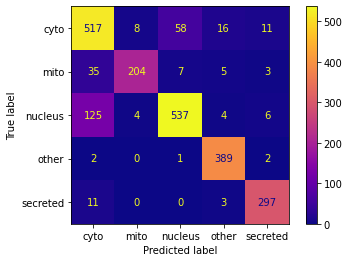

In [41]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Get true labels from the test_dataset
y_test = test_dataset["labels"]

# Compute confusion matrix
labels = ['cyto', 'mito', 'nucleus', 'other', 'secreted']
cm = confusion_matrix(y_test, class_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='plasma')

plt.show()

In [45]:
f1_score(y_test, class_predictions, average='weighted')

0.866157893539859

# Blind Predictions

In [46]:
from Bio import SeqIO
d = {'id':[], 'seq':[]}
files = ['blind.fasta.txt']
for i in range(len(files)):
  for seq_record in SeqIO.parse(open(drive_path+files[i]),'fasta'):
    d['id'].append(seq_record.id)
    d['seq'].append(''.join(seq_record.seq))
df = pd.DataFrame(d)

In [55]:
final_tokenized = tokenizer(list(df.seq.values), padding='max_length', truncation=True, max_length=1024)
final_dataset = Dataset.from_dict(final_tokenized)
predictions = trainer.predict(final_dataset)

logits = predictions.predictions
# For class predictions
class_predictions = np.argmax(logits, axis=-1)

# For probabilities
probabilities = np.exp(logits) / np.exp(logits).sum(axis=-1, keepdims=True)

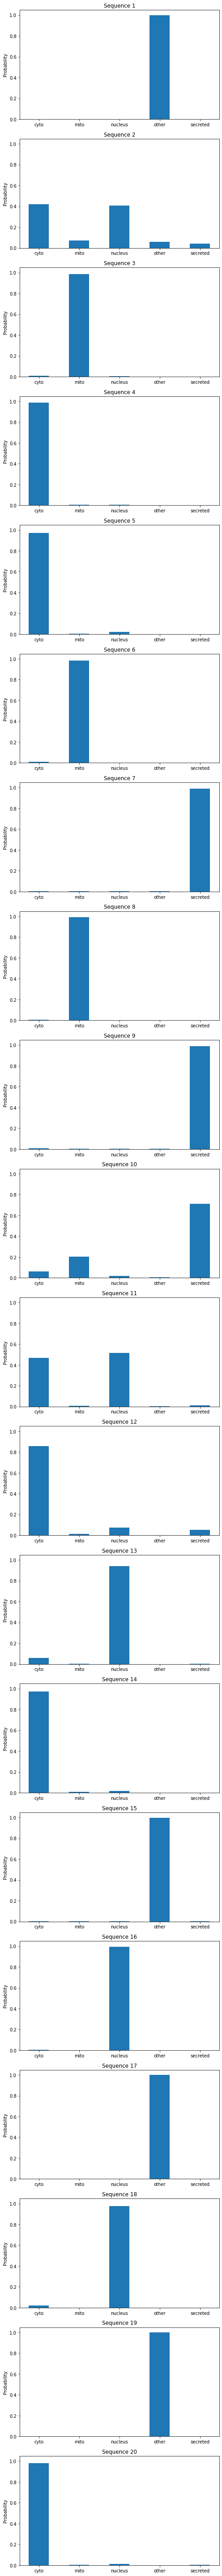

In [60]:
labels = ['cyto', 'mito', 'nucleus', 'other', 'secreted']
num_sequences = probabilities.shape[0]
num_classes = probabilities.shape[1]

x = np.arange(num_classes)
width = 0.5

fig, axs = plt.subplots(num_sequences, figsize=(7, 4 * num_sequences), sharey=True)

for i, ax in enumerate(axs):
    ax.bar(x, probabilities[i], width)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.set_ylabel('Probability')
    ax.set_title(f'Sequence {i + 1}')

plt.tight_layout()
plt.show()

In [63]:
trainer.save_model("gdrive/MyDrive/Colab Notebooks/final_model")